# transversity

In [1]:
import sys,os
os.chdir('../../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest

## setup

In [2]:
path='outputs/transversity/transversity-lattice-1'

In [3]:
conf=load_config('%s/transversity-lattice-1.py'%path)
resman=RESMAN(conf);
parman=resman.conf['parman']

loading moments data sets 1000

In [4]:
NEST={}
for i in range(10):
    fname='%s/nest%d'%(path,i)
    if os.path.isfile(fname):
        NEST[i]=load(fname)

In [5]:
NEST[0].keys()

['active nll', 'samples', 'logz', 'l', 'weights', 'active p', 'x']

## analyze nested sampling statistics

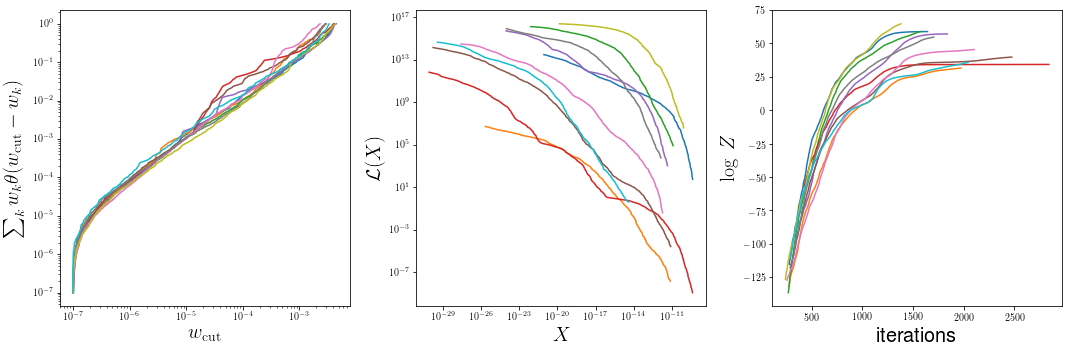

In [6]:
wmin_cut=1e-7
nrows,ncols=1,3
py.figure(figsize=(ncols*5,nrows*5))

ax=py.subplot(nrows,ncols,1)
for k in NEST:
    nest=NEST[k]
    weights=np.copy(nest['weights'])
    weights=[w for w in weights if w>wmin_cut]
    wmin=np.amin(weights)
    wmax=np.amax(weights)
    w=10**np.linspace(np.log10(wmin),np.log10(wmax),1000)
    wsum=lambda wcut: np.sum([w for w in weights if w<wcut])
    ax.plot(w,[wsum(wcut) for wcut in w])
ax.semilogx();
ax.semilogy();
ax.set_ylabel(r'$\sum_k w_k \theta(w_{\rm cut}-w_k)$',size=20)
ax.set_xlabel(r'$w_{\rm cut}$',size=20)

ax=py.subplot(nrows,ncols,2)
for k in NEST:
    nest=NEST[k]
    X=[nest['x'][i] for i in range(len(nest['x'])) if nest['weights'][i]>wmin_cut]
    L=[nest['l'][i] for i in range(len(nest['l'])) if nest['weights'][i]>wmin_cut]
    ax.plot(X,L)
    ax.semilogx()
    ax.semilogy()
    ax.set_ylabel(r'${\cal L}(X)$',size=20)
    ax.set_xlabel(r'$X$',size=20)

ax=py.subplot(nrows,ncols,3)
for k in NEST:
    nest=NEST[k]
    it=[i for i in range(len(nest['x'])) if nest['weights'][i]>wmin_cut]
    LOGZ=[nest['logz'][i] for i in range(len(nest['l'])) if nest['weights'][i]>wmin_cut]
    ax.plot(it,LOGZ)
    ax.set_ylabel(r'$\log \;Z$',size=20)
    ax.set_xlabel(r'iterations',size=20)

py.tight_layout()

## Select the best sample as the one with the lowest chi2

In [8]:
D={'idx':[],'nll':[],'logz':[]}
for k in NEST:
    nest=NEST[k]
    D['idx'].append(k)
    D['nll'].append(np.amin(nest['active nll']))
    D['logz'].append(nest['logz'][-1])

D=pd.DataFrame(D).sort_values(by='logz')
median=D['logz'].median()
best=D.idx.values[np.argmin(np.abs(D.logz-median))]
print 'best=',best
print 'median=',median
print D.logz[best]
print D

best= 7
median= 51.5902090318
57.6681616763
   idx       logz        nll
1    1  32.642778 -16.463700
3    3  34.205834 -31.555830
5    5  40.267301 -34.069687
9    9  42.222010 -35.660448
6    6  46.070659 -33.930066
4    4  57.109759 -40.140346
7    7  57.668162 -38.082771
0    0  58.822503 -32.242321
2    2  62.514090 -38.252216
8    8  68.350914 -37.906536


## parameters

In [9]:
def plot_params(k,kk):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        pmin=conf['params'][k][kk[i]]['min']
        pmax=conf['params'][k][kk[i]]['max']
        for key in NEST:
            nest=NEST[key]
            weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
            samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
            weights/=np.sum(weights)
            par=np.transpose(samples)[get_idx(kk[i])]
            mean=np.einsum('k,k',weights,par) 
            std=np.einsum('k,k',weights,(np.array(par)-mean)**2)**0.5 
            if best==key:
                ax.hist(par,histtype='stepfilled',weights=weights,bins=10,facecolor='Yellow',edgecolor='k',range=(pmin,pmax))
            else:
                ax.hist(par,histtype='step',weights=weights,bins=10,range=(pmin,pmax))
        ax.set_xlim(pmin,pmax)
        #par=samples[get_idx(kk[i])]
        #ax.hist(par,histtype='stepfilled',weights=nes['weights'],range=(pmin,pmax),bins=10,facecolor='Yellow',edgecolor='k')        ax.hist(par1,histtype='stepfilled',weights=core1.nes['weights'],range=(pmin,pmax),bins=10,facecolor='none',edgecolor='r',hatch='...')
        ax.set_title('%s-%s'%(k,kk[i]))
        #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    py.tight_layout()


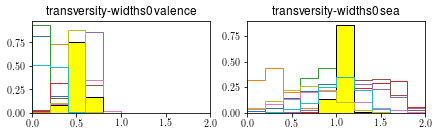

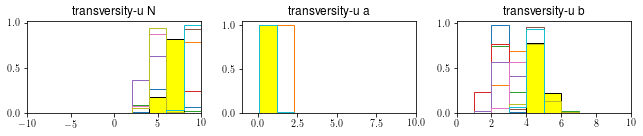

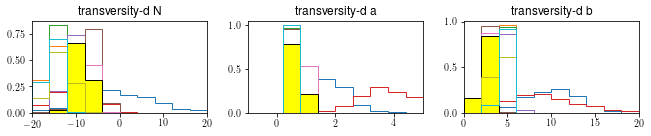

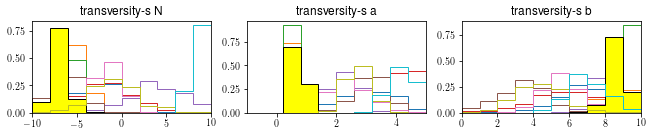

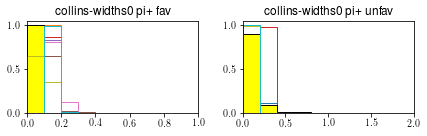

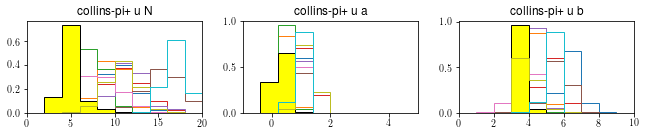

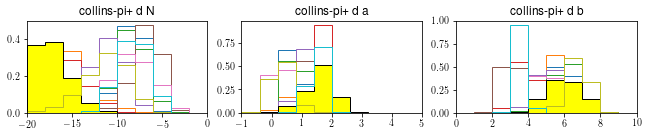

In [10]:
plot_params('transversity',['widths0 valence','widths0 sea'])
plot_params('transversity',['u N','u a','u b'])
plot_params('transversity',['d N','d a','d b'])
plot_params('transversity',['s N','s a','s b'])
plot_params('collins',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params('collins',['pi+ u N','pi+ u a','pi+ u b'])
plot_params('collins',['pi+ d N','pi+ d a','pi+ d b'])
# plot_params('collins',['widths0 k+ fav','widths0 k+ unfav'])
# plot_params('collins',['k+ u N','k+ u a','k+ u b'])
# plot_params('collins',['k+ d N','k+ d a','k+ d b'])
# plot_params('collins',['k+ sb N','k+ sb a','k+ sb b'])

## Analyze the best run. First remove samples using sum_w cut criterion.  

In [11]:
nest=NEST[best]
wmax=np.amax(nest['weights'])
wmin_cut=wmax*1e-7
weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
weights/=np.sum(weights)
print 'initial size=%d  final size=%d'%(len(nest['samples']),len(samples))

initial size=3080  final size=1850


## 2D parameters hist 

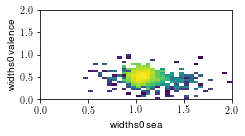

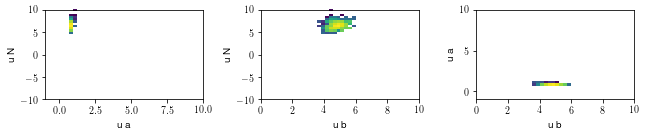

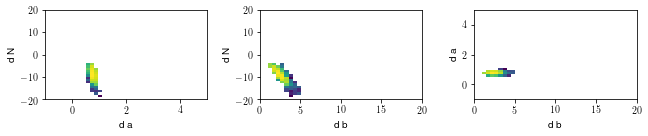

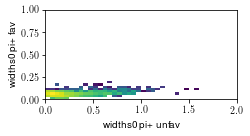

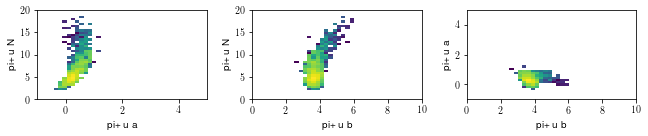

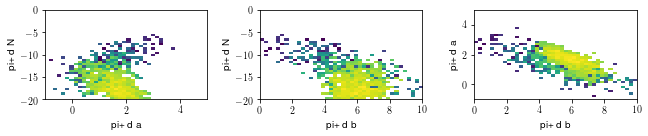

In [12]:
def plot_corr(k,kk):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    pars=np.transpose(samples)#[get_idx(kk[i])]

    cnt=0
    for i in range(len(kk)):
        pmin1=conf['params'][k][kk[i]]['min']
        pmax1=conf['params'][k][kk[i]]['max']
        par1=pars[get_idx(kk[i])]
        for j in range(len(kk)):
            if i<=j: continue
            cnt+=1
            ax=py.subplot(nrows,ncols,cnt)
            pmin2=conf['params'][k][kk[j]]['min']
            pmax2=conf['params'][k][kk[j]]['max']
            par2=pars[get_idx(kk[j])]
            plims=[[pmin1,pmax1],[pmin2,pmax2]]
            ax.hist2d(par1,par2,bins=40,range=plims,weights=weights,norm=LogNorm())    
            ax.set_xlabel(kk[i])
            ax.set_ylabel(kk[j])
    py.tight_layout()

plot_corr('transversity',['widths0 valence','widths0 sea'])
plot_corr('transversity',['u N','u a','u b'])
plot_corr('transversity',['d N','d a','d b'])
plot_corr('collins',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_corr('collins',['pi+ u N','pi+ u a','pi+ u b'])
plot_corr('collins',['pi+ d N','pi+ d a','pi+ d b'])
# plot_corr('collins',['widths0 k+ fav','widths0 k+ unfav'])
# plot_corr('collins',['k+ u N','k+ u a','k+ u b'])
# plot_corr('collins',['k+ d N','k+ d a','k+ d b'])
# plot_corr('collins',['k+ sb N','k+ sb a','k+ sb b'])

## Kinematics

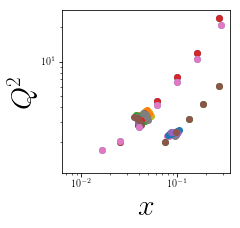

In [12]:
nrows,ncols=1,1
py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(111)
for k in conf['datasets']['sidis']['xlsx']: 
    x=resman.sidisres.tabs[k]['x']
    Q2=resman.sidisres.tabs[k]['Q2']
    ax.scatter(x,Q2)
ax.set_ylabel(r'$Q^2$',size=30)
ax.set_xlabel(r'$x$',size=30)
ax.semilogx()
ax.semilogy();

## data vs theory

In [16]:
def get_RAW():
    RAW={}
    for k in conf['datasets']: 
        RAW[k]={}
        for kk in conf['datasets'][k]['xlsx']: 
            RAW[k][kk]=[]
    return RAW

THY=get_RAW()
RES=get_RAW()
bar=BAR('gen chi2 values',len(samples))
for ii in range(len(samples)):
    par=samples[ii]
    resman.get_residuals(par)
    for k in RES:
        if k=='sidis': 
            for kk in RES[k]: 
                THY[k][kk].append(np.copy(resman.sidisres.tabs[kk]['thy']))
                RES[k][kk].append(np.copy(resman.sidisres.tabs[kk]['residuals']))
        if k=='moments': 
            for kk in RES[k]:
                THY[k][kk].append(np.copy(resman.momres.tabs[kk]['thy']))
                RES[k][kk].append(np.copy(resman.momres.tabs[kk]['residuals']))
    bar.next()
bar.finish()
RAW={'THY':THY,'RES':RES}
save(RAW,'%s/raw%d'%(path,best))

gen chi2 values [100%]


In [17]:
RAW=load('%s/raw%d'%(path,best))
RES=RAW['RES']
THY=RAW['THY']

for k in RES:
    for kk in RES[k]: 
        if k=='sidis': 
            thy =np.einsum('k,ki',weights,np.array(THY[k][kk]))
            dthy=np.einsum('k,ki',weights,(np.array(THY[k][kk])-thy)**2)**0.5
            residuals=np.einsum('k,ki',weights,RES[k][kk])
            resman.sidisres.tabs[kk]['thy']=thy
            resman.sidisres.tabs[kk]['dthy']=dthy
            tab=resman.sidisres.tabs[kk]
            resman.sidisres.tabs[kk]['chi2']=residuals**2
            resman.sidisres.tabs[kk]=pd.DataFrame(resman.sidisres.tabs[kk])

In [18]:
NPTS=0
CHI2=0
D={}
for k in ['had','tar','dep','col','chi2','npts','chi2/npt']: D[k]=[]
for k in RES:
    for kk in RES[k]:
        if k=='sidis':
            npts=resman.sidisres.tabs[kk]['value'].size
            chi2=np.sum(resman.sidisres.tabs[kk]['chi2'])
            D['tar'].append(resman.sidisres.tabs[kk]['target'].values[0])
            D['dep'].append(resman.sidisres.tabs[kk]['dependence'].values[0])
            D['col'].append(resman.sidisres.tabs[kk]['col'].values[0].upper().strip())
            D['had'].append(resman.sidisres.tabs[kk]['hadron'].values[0])
            D['npts'].append(npts)
            D['chi2'].append(chi2)
            D['chi2/npt'].append(chi2/npts)
D=pd.DataFrame(D)
D = D[['col', 'tar', 'had', 'dep', 'npts','chi2','chi2/npt']]
D=D.sort_values(by=['col','tar'])
print D.to_string(index=False)
print '\nNtot =',np.sum(D.npts)
print 'Chi2tot =',np.sum(D.chi2)

col       tar  had dep  npts       chi2  chi2/npt
COMPASS  deuteron  pi+   x     6   4.271702  0.711950
COMPASS  deuteron  pi+  pT     6   4.149821  0.691637
COMPASS  deuteron  pi+   z     6   2.539263  0.423211
COMPASS  deuteron  pi-   x     6   8.615866  1.435978
COMPASS  deuteron  pi-  pT     6   5.525706  0.920951
COMPASS  deuteron  pi-   z     6   6.274615  1.045769
COMPASS  deuteron   k+   x     7  12.032462  1.718923
COMPASS  deuteron   k+  pT     6   4.163514  0.693919
COMPASS  deuteron   k+   z     6   0.658168  0.109695
COMPASS  deuteron   k-   x     7  10.791392  1.541627
COMPASS  deuteron   k-  pT     6   4.463046  0.743841
COMPASS  deuteron   k-   z     6   5.934547  0.989091
COMPASS    proton  pi-   x     7   4.678544  0.668363
COMPASS    proton  pi+   z     6   2.712433  0.452072
COMPASS    proton  pi-  pt     6   1.158949  0.193158
COMPASS    proton  pi-   z     6   8.778922  1.463154
COMPASS    proton  pi+   x     7   5.419816  0.774259
COMPASS    proton  pi+  pt     6

## AUT plot

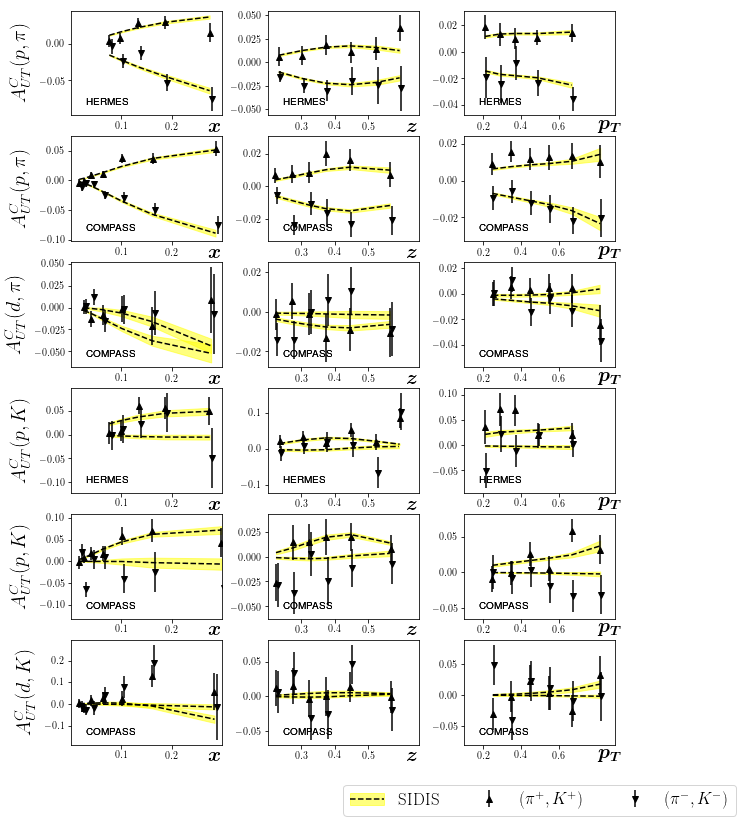

In [19]:
def get_key(K,tar,had,col,tabs,dep):
    kk=None
    for k in K:
        d=tabs[k]
        #print '-->',d['target'].values[0],d['hadron'].values[0],d['col'].values[0].upper()
        if tar==d['target'].values[0] \
            and had==d['hadron'].values[0] \
            and dep==d['dependence'].values[0] \
            and col==d['col'].values[0].upper().strip(): kk=k
    return kk

tabs=resman.sidisres.tabs
def plot(idx,dep,tar,had,col,legend=False):
    #print tar,had,col
    k=get_key(tabs.keys(),tar,had,col,tabs,dep)
    d1=resman.sidisres.tabs[k]
    ax=py.subplot(nrows,ncols,idx)
    dep=d1['dependence'].values[0]
    #obs=d['obs'].values[0]
    tar=d1['target'].values[0]
    had=d1['hadron'].values[0]
    if dep=='pt': dep='pT'
    sign=1
    if col=='COMPASS': sign=-1
    shift=0
    if '-' in had:shift=0.005
    if '-' in had: e=ax.errorbar(d1[dep]+shift,sign*d1['value'],d1['alpha'],fmt='kv')
    if '+' in had: e=ax.errorbar(d1[dep]+shift,sign*d1['value'],d1['alpha'],fmt='k^')
    b1=ax.fill_between(d1[dep],sign*(d1['thy']-d1['dthy']),sign*(d1['thy']+d1['dthy']),color='Yellow',alpha=0.5)
    l1,=ax.plot(d1[dep],sign*d1['thy'],'k--')
    if dep=='x': ax.set_xlabel(r'$\boldsymbol{x}$',size=20)
    if dep=='z': ax.set_xlabel(r'$\boldsymbol{z}$',size=20)
    if dep=='pT': ax.set_xlabel(r'$\boldsymbol{p_T}$',size=20)
    ax.xaxis.set_label_coords(0.95, -0.02)
    if dep=='x':
        ax.set_xlim(0,0.3)
        ax.set_xticks([0.1,0.2])
    if dep=='z':
        ax.set_xlim(0.2,0.65)
        ax.set_xticks([0.3,0.4,0.5])
    if dep=='pT':
        ax.set_xlim(0.1,0.9)
        ax.set_xticks([0.2,0.4,0.6])

    #if dep=='pT':ax.set_xlim(0.2,0.65)
    #ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.tick_params(axis='both', which='major', labelsize=20)
    #ax.set_ylabel(obs)
    #ax.set_title('%s %s %s'%(tar,had.replace('+','').replace('-',''),col))
    #ax.set_xlim(0,0.3)
    #ax.set_ylim(-.1,.1)
    #ax.set_xticklabels([])
    ax.text(0.1,0.1,col,transform=ax.transAxes,size=10)
    if legend: return ax,(b1,l1),e
    else: return ax


nrows,ncols=6,3
py.figure(figsize=(ncols*3,nrows*2))

ax=plot(1,'x','proton','pi+','HERMES')
ax=plot(1,'x','proton','pi-','HERMES')
ax.set_ylabel(r'$A_{UT}^{C}(p,\pi)$',size=20)
ax=plot(2,'z','proton','pi+','HERMES')
ax=plot(2,'z','proton','pi-','HERMES')
ax=plot(3,'pt','proton','pi+','HERMES')
ax=plot(3,'pt','proton','pi-','HERMES')

ax=plot(4,'x','proton','pi+','COMPASS')
ax=plot(4,'x','proton','pi-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(p,\pi)$',size=20)
ax=plot(5,'z','proton','pi+','COMPASS')
ax=plot(5,'z','proton','pi-','COMPASS')
ax=plot(6,'pt','proton','pi+','COMPASS')
ax=plot(6,'pt','proton','pi-','COMPASS')

ax=plot(7,'x','deuteron','pi+','COMPASS')
ax=plot(7,'x','deuteron','pi-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(d,\pi)$',size=20)
ax=plot(8,'z','deuteron','pi+','COMPASS')
ax=plot(8,'z','deuteron','pi-','COMPASS')
ax=plot(9,'pT','deuteron','pi+','COMPASS')
ax=plot(9,'pT','deuteron','pi-','COMPASS')

ax=plot(10,'x','proton','k+','HERMES')
ax=plot(10,'x','proton','k-','HERMES')
ax.set_ylabel(r'$A_{UT}^{C}(p,K)$',size=20)
ax=plot(11,'z','proton','k+','HERMES')
ax=plot(11,'z','proton','k-','HERMES')
ax=plot(12,'pt','proton','k+','HERMES')
ax=plot(12,'pt','proton','k-','HERMES')

ax=plot(13,'x','proton','k+','COMPASS')
ax=plot(13,'x','proton','k-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(p,K)$',size=20)
ax=plot(14,'z','proton','k+','COMPASS')
ax=plot(14,'z','proton','k-','COMPASS')
ax=plot(15,'pt','proton','k+','COMPASS')
ax=plot(15,'pt','proton','k-','COMPASS')


ax=plot(16,'x','deuteron','k+','COMPASS')
ax=plot(16,'x','deuteron','k-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(d,K)$',size=20)
ax,b1,ep=plot(17,'z','deuteron','k+','COMPASS',legend=True)
ax,b1,em=plot(17,'z','deuteron','k-','COMPASS',legend=True)
ax=plot(18,'pT','deuteron','k+','COMPASS')
ax=plot(18,'pT','deuteron','k-','COMPASS')
ax.legend([b1,ep,em],[r'$\rm SIDIS$',r'$(\pi^+,K^+)$',r'$(\pi^-,K^-)$']\
          ,loc='upper center', bbox_to_anchor=(0.5, -0.3)\
          ,fancybox=True, shadow=False, ncol=4,fontsize=17)

py.subplots_adjust(wspace=0.3, hspace=0.2,left=0.11, bottom=0.1, right=0.95, top=0.95)
#py.savefig('gallery/dvt.pdf')

## PDFs and FFs

In [18]:
def calc(func,msg):
    RAW=[]
    bar=BAR(msg,len(samples))
    for i in range(len(samples)):
        par=samples[i]
        parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',weights,RAW)
    df=np.einsum('k,kif->if',weights,(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

In [19]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h1=calc(lambda : [resman.conf['transversity'].get_C(x,1) for x in X],'calc h')

calc h [100%]


In [20]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hpi1=calc(lambda : [resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')

calc H(pi+) [100%]


In [21]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hk1=calc(lambda : [resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')

calc H(k+) [100%]


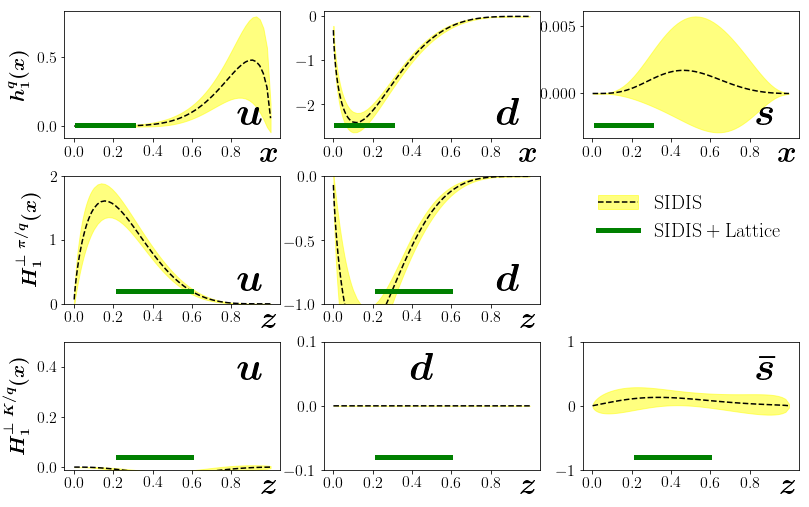

In [24]:
def get_kinematics():
    tabs=resman.sidisres.tabs
    X,Z,Q2,pT=[],[],[],[]
    for k in tabs:X=np.append(tabs[k]['x'],X)
    for k in tabs:Z=np.append(tabs[k]['z'],Z)
    for k in tabs:Q2=np.append(tabs[k]['Q2'],Q2)
    for k in tabs:pT=np.append(tabs[k]['pT'],pT)
    return {'X':X,'Z':Z,'Q2':Q2,'pT':pT}
kin=get_kinematics()

nrows,ncols=3,3
py.figure(figsize=(ncols*4,nrows*2.5))

def plot(idx,flav,legend=False,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(X,(h1['f'][flav]-h1['df'][flav]),(h1['f'][flav]+h1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(X,h1['f'][flav],'k--')
    #band2=ax.fill_between(X,(h2['f'][flav]-h2['df'][flav]),(h2['f'][flav]+h2['df'][flav]),color='r',alpha=0.5)
    #line2,=ax.plot(X,h2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{x}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    xmin=np.amin(kin['X'])
    xmax=np.amax(kin['X'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax
 
def plotpi(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hpi1['f'][flav]-Hpi1['df'][flav]),(Hpi1['f'][flav]+Hpi1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hpi1['f'][flav],'k--')
    #band2=ax.fill_between(Z,(Hpi2['f'][flav]-Hpi2['df'][flav]),(Hpi2['f'][flav]+Hpi2['df'][flav]),color='r',alpha=0.5)
    #line2,=ax.plot(Z,Hpi2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax,(band1,line1),line

def plotk(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hk1['f'][flav]-Hk1['df'][flav]),(Hk1['f'][flav]+Hk1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hk1['f'][flav],'k--')
    #band2=ax.fill_between(Z,(Hk2['f'][flav]-Hk2['df'][flav]),(Hk2['f'][flav]+Hk2['df'][flav]),color='r',alpha=0.5)
    #line2,=ax.plot(Z,Hk2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax

ax=plot(1,1)
ax.set_ylabel(r'$\boldsymbol{h_1^q(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax=plot(2,3)
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plot(3,5)
ax.text(0.8,0.1,r'$\boldsymbol{s}$',size=40,transform=ax.transAxes)

ax,b1,l=plotpi(4,1,[0,2])
ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~\pi/q}(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax,b1,l=plotpi(5,3,[-1,.0])
ax.legend([b1,l],[r'$\rm SIDIS$',r'$\rm SIDIS+Lattice$',r'$\rm SIDIS~coverage$']\
    ,fontsize=20,frameon=False,loc=1,bbox_to_anchor=(2.2, 1))
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plotk(7,1,[-0.01,0.5])
ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~K/q}(x)}$',size=20)
ax.text(0.8,0.7,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax=plotk(8,3,[-0.1,0.1])
ax.text(0.4,0.7,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plotk(9,6,[-1,1])
ax.text(0.8,0.7,r'$\boldsymbol{\bar{s}}$',size=40,transform=ax.transAxes)

py.subplots_adjust(wspace=0.2, hspace=0.3,left=0.1, bottom=0.1, right=0.95, top=0.95)
#py.tight_layout()
#py.savefig('gallery/transversity-collins.pdf')
